### 1. Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, :2]  # Take only the first two features
y = iris.target

# Take only the setosa and versicolor flowers
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

### 2. Visualizing the Data

In [3]:
def plot_data(X, y):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=iris.target_names[y], style=iris.target_names[y], 
                    palette=['r','b'], markers=('s','o'), edgecolor='k')
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.legend()    

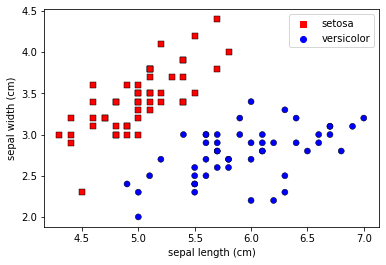

In [4]:
plot_data(X, y)
plt.savefig('figures/iris_data.pdf')

In [5]:
# Add a column for the bias
n = X.shape[0] 
X_with_bias = np.hstack((np.ones((n, 1)), X))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_with_bias, y, random_state=0)

### 3. Model Implementation

Logistic regression hypothesis: 

$$h_\textbf{w}(\textbf{x}) = \sigma(\textbf{w}^T\textbf{x})$$

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

#### 3.1 Sigmoid function

In [7]:
def sigmoid(z):
    """ Compute the sigmoid of z (z can be a scalar or a vector). """
    z = np.array(z)
    return 1 / (1 + np.exp(-z))

#### 3.2 Cost function and gradient

Cost function in logistic regression is:

$$J(\textbf{w}) = -\frac{1}{n}\sum_{i=1}^n\left[y_i \log(h_\textbf{w}(\textbf{x}_i))+(1-y_i)\log(1-h_\textbf{w}(\textbf{x}_i))\right]$$

Vectorized implementation:

$\textbf{h} = \sigma(X\textbf{w})$

$J(\textbf{w}) = \frac{1}{n}(-\textbf{y}^T \log(\textbf{h})-(1-\textbf{y})^T\log(1-\textbf{h}))$



The gradient of the cost is a vector of the same length as $\textbf{w}$ where $j^{th}$ element (for $j=0,1,...,m$) is defined as follows:

$$\frac{\partial J(\textbf{w})}{\partial w_j} = \frac{1}{n} \sum_{i=1}^n [(h_\textbf{w}(\textbf{x}_i) - y_i) \cdot x_{ij}]$$

Vectorized:
$\nabla J(\textbf{w}) = \frac{1}{n} \cdot X^T \cdot (\sigma(X\textbf{w}) - \textbf{y})$

In [8]:
def cost_function(X, y, w):
    """ J, grad = cost_function(X, y, w) computes the cost of a logistic regression model 
        with parameters w and the gradient of the cost w.r.t. to the parameters. """
    # Compute the cost
    h = sigmoid(X @ w)    
    J = (1/n) * (-y @ np.log(h) - (1-y) @ np.log(1-h)) 
    
    # Compute the gradient    
    grad = (1/n) * X.T @ (h - y)  
    return J, grad

In [9]:
initial_w = np.zeros(shape=(X_train.shape[1]))
cost, grad = cost_function(X_train, y_train, initial_w)

print('Cost at initial w (zeros):', cost)
print('Gradient at initial w (zeros):', grad)

Cost at initial w (zeros): 0.5198603854199589
Gradient at initial w (zeros): [-0.005  -0.1885  0.109 ]


#### 3.3 Gradient descent

In [10]:
def optimize_model(X, y, alpha=0.01, max_iter=5000, tol=0.0001):
    """ Optimize the model using gradient descent.
        X, y: The training set        
        alpha: The learning rate
        max_iter: The maximum number of passes over the training set (epochs)
        tol: The stopping criterion. Training will stop when (new_cost > cost - tol)
    """
    w = np.random.rand(X.shape[1])
    cost, grad = cost_function(X, y, w)
    
    for i in range(max_iter + 1):
        w = w - alpha * grad
        new_cost, grad = cost_function(X, y, w)        
        #if new_cost > cost - tol:
        #    print(f'Converged after {i} iterations')
        #    return w, new_cost
        cost = new_cost
    
    print('Maximum number of iterations reached')
    return w, cost

In [11]:
opt_w, cost = optimize_model(X_train, y_train)

print('opt_w:', opt_w)
print('Cost at opt_w:', cost)

Maximum number of iterations reached
opt_w: [ 0.035663    1.92631562 -3.37122091]
Cost at opt_w: 0.1410498179812223


### 4. Using the Model for Predictions

In [12]:
def predict_prob(X, w):
    """ Return the probability that samples in X belong to the positive class (label 1)
        X: the feature matrix (every row in X represents one sample)
        w: the learned logistic regression parameters  
    """
    h = sigmoid(X @ w)
    return h

In [13]:
predict_prob([[1, 6, 2]], opt_w)

array([0.99224102])

In [14]:
predict_prob([[1, 5.5, 3]], opt_w)

array([0.62638426])

In [15]:
def predict(X, w):
    """ Predict whether the label is 0 or 1 for the samples in X using a threshold of 0.5
        (i.e., if sigmoid(X @ theta) >= 0.5, predict 1)
    """
    h = sigmoid(X @ w)
    y_pred = (h >= 0.5).astype(int)
    return y_pred

In [16]:
predict([[1, 6, 2], [1, 5.5, 3]], opt_w)

array([1, 1])

### 5. Evaluating the Model

In [17]:
def evaluate_model(X, y, w):
    y_pred = predict(X, w)
    accuracy = np.mean(y == y_pred)
    return accuracy

#### 4.1 Accuracy on the training set

In [18]:
train_accuracy = evaluate_model(X_train, y_train, opt_w)
print(f'Train accuracy: {train_accuracy * 100:.3f}%')

Train accuracy: 98.667%


In [19]:
test_accuracy = evaluate_model(X_test, y_test, opt_w)
print(f'Test accuracy: {test_accuracy * 100:.3f}%')

Test accuracy: 100.000%


#### 4.2 Decision boundary

In [20]:
def plot_decision_boundary(X, y, w):
    """ Plot the decision boundary between the classes """
    plot_data(X, y)
    
    line_x = np.array(plt.gca().get_xlim())
    line_y = -1 / w[2] * (w[1] * line_x + w[0])
    plt.plot(line_x, line_y, c='k', ls='--')

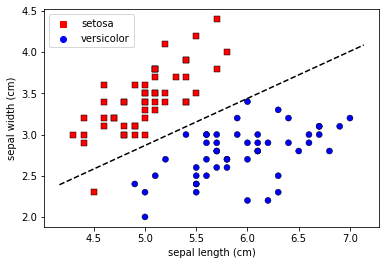

In [21]:
plot_decision_boundary(X, y, opt_w)
plt.savefig('figures/decision_boundary.pdf')